## Import Requisite Libraries

In [1]:
import pandas as pd
import numpy as np
import os

from ucimlrepo import fetch_ucirepo

from eda_toolkit import (
    ensure_directory,
    kde_distributions,
    data_doctor,
    strip_trailing_period,
    stacked_crosstab_plot,
    box_violin_plot,
    scatter_fit_plot,
    flex_corr_matrix,
)

## Ensure Directory

In [2]:
base_path = os.path.join(os.pardir)

# Go up one level from 'notebooks' to parent directory,
# then into the 'data' folder
data_path = os.path.join(os.pardir, "data")
data_output = os.path.join(os.pardir, "data_output")

# create image paths
image_path_png = os.path.join(base_path, "images", "png_images")
image_path_svg = os.path.join(base_path, "images", "svg_images")

# Use the function to ensure'data' directory exists
ensure_directory(data_path)
ensure_directory(data_output)
ensure_directory(image_path_png)
ensure_directory(image_path_svg)

Directory exists: ../data
Directory exists: ../data_output
Directory exists: ../images/png_images
Directory exists: ../images/svg_images


## UCI ML Repository

In [3]:
# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

# Combine X and y into entire df
df = X.join(y, how="inner")

df.to_csv(os.path.join(data_path, "adult_income.csv"))

In [4]:
## Reload dataframe since a ton of `data_doctor` columns were added from above;
## this would cause too many additional columns to loop through; not necessary
## for this reproducible example, especially when it comes to saving so many files
df = pd.read_csv(os.path.join(data_path, "adult_income.csv"))
df = df.drop(columns=["Unnamed: 0"])

## Binning Numerical Columns

In [5]:
bin_ages = [
    0,
    18,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100,
    float("inf"),
]

In [6]:
label_ages = [
    "< 18",
    "18-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-89",
    "90-99",
    "100 +",
]

In [7]:
df["age_group"] = pd.cut(
    df["age"],
    bins=bin_ages,
    labels=label_ages,
    right=False,
)

In [8]:
exclude_combinations = [
    ("capital-gain", "hours-per-week"),
    ("capital-loss", "capital-gain"),
    ("capital-loss", "hours-per-week"),
    ("capital-loss", "education-num"),
    ("capital-loss", "fnlwgt"),
    ("education-num", "hours-per-week"),
    ("hours-per-week", "age"),
]

scatter_fit_plot(
    df=df,
    all_vars=df.select_dtypes(np.number).columns.to_list(),
    show_legend=True,
    exclude_combinations=exclude_combinations,
    show_plot="combinations",
    label_fontsize=14,
    tick_fontsize=12,
    add_best_fit_line=True,
    scatter_color="#808080",
    show_correlation=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plots="grid",
)

[('age', 'fnlwgt'),
 ('age', 'education-num'),
 ('age', 'capital-gain'),
 ('age', 'capital-loss'),
 ('fnlwgt', 'education-num'),
 ('fnlwgt', 'capital-gain'),
 ('fnlwgt', 'hours-per-week'),
 ('education-num', 'capital-gain')]

## KDE and Histograms

/tmp/ipykernel_164646/3708547270.py:7: DeprecationWarning: `kde_distributions` is deprecated and will be removed in a future release. Use `plot_distributions` instead.
  kde_distributions(


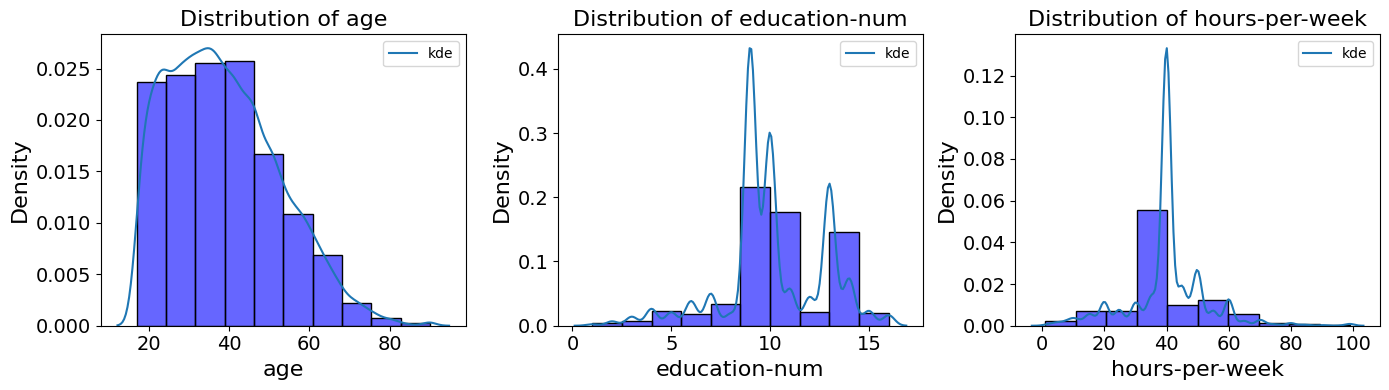

In [9]:
vars_of_interest = [
    "age",
    "education-num",
    "hours-per-week",
]

kde_distributions(
    df=df,
    n_rows=1,
    n_cols=3,
    subplot_figsize=(14, 4),  # Size of the overall grid figure
    fill=True,
    fill_alpha=0.60,
    text_wrap=50,
    bbox_inches="tight",
    vars_of_interest=vars_of_interest,
    y_axis_label="Density",
    bins=10,
    plot_type="both",  # Can also just plot KDE by itself by passing "kde"
    label_fontsize=16,  # Font size for axis labels
    tick_fontsize=14,  # Font size for tick labels
    image_filename="age_distribution_kde",
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

### Histogram Example (Density)

/tmp/ipykernel_164646/3580171814.py:7: DeprecationWarning: `kde_distributions` is deprecated and will be removed in a future release. Use `plot_distributions` instead.
  kde_distributions(


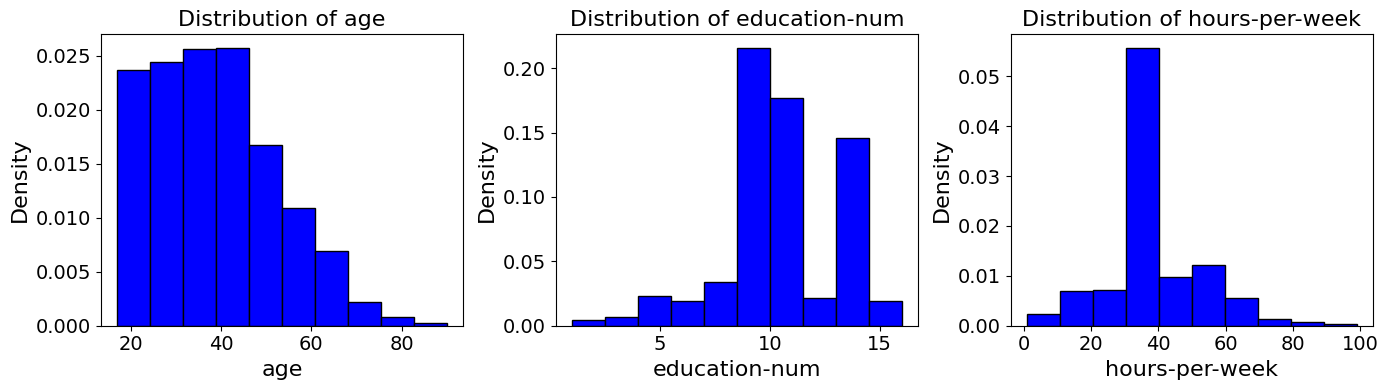

In [10]:
vars_of_interest = [
    "age",
    "education-num",
    "hours-per-week",
]

kde_distributions(
    df=df,
    n_rows=1,
    n_cols=3,
    subplot_figsize=(14, 4),  # Size of the overall grid figure
    fill=True,
    text_wrap=50,
    bbox_inches="tight",
    vars_of_interest=vars_of_interest,
    y_axis_label="Density",
    bins=10,
    plot_type="hist",
    label_fontsize=16,  # Font size for axis labels
    tick_fontsize=14,  # Font size for tick labels
    image_filename="age_distribution_density",
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

### Histogram Example (Count)

/tmp/ipykernel_164646/462178673.py:7: DeprecationWarning: `kde_distributions` is deprecated and will be removed in a future release. Use `plot_distributions` instead.
  kde_distributions(


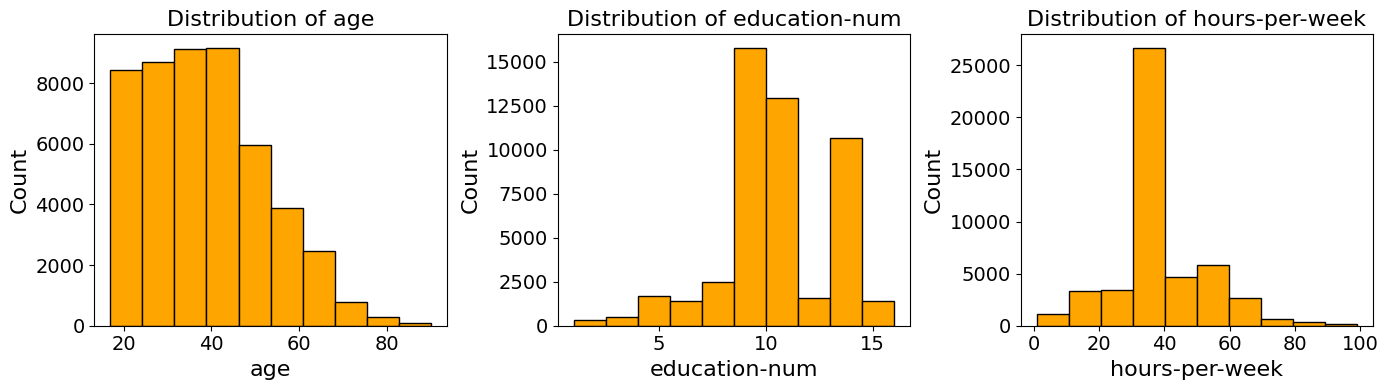

In [11]:
vars_of_interest = [
    "age",
    "education-num",
    "hours-per-week",
]

kde_distributions(
    df=df,
    n_rows=1,
    n_cols=3,
    subplot_figsize=(14, 4),  # Size of the overall grid figure
    text_wrap=50,
    hist_color="orange",
    bbox_inches="tight",
    vars_of_interest=vars_of_interest,
    y_axis_label="Count",
    bins=10,
    plot_type="hist",
    stat="Count",
    label_fontsize=16,  # Font size for axis labels
    tick_fontsize=14,  # Font size for tick labels
    image_filename="age_distribution_count",
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

### Histogram Example - (Mean and Median)

/tmp/ipykernel_164646/3281326533.py:7: DeprecationWarning: `kde_distributions` is deprecated and will be removed in a future release. Use `plot_distributions` instead.
  kde_distributions(


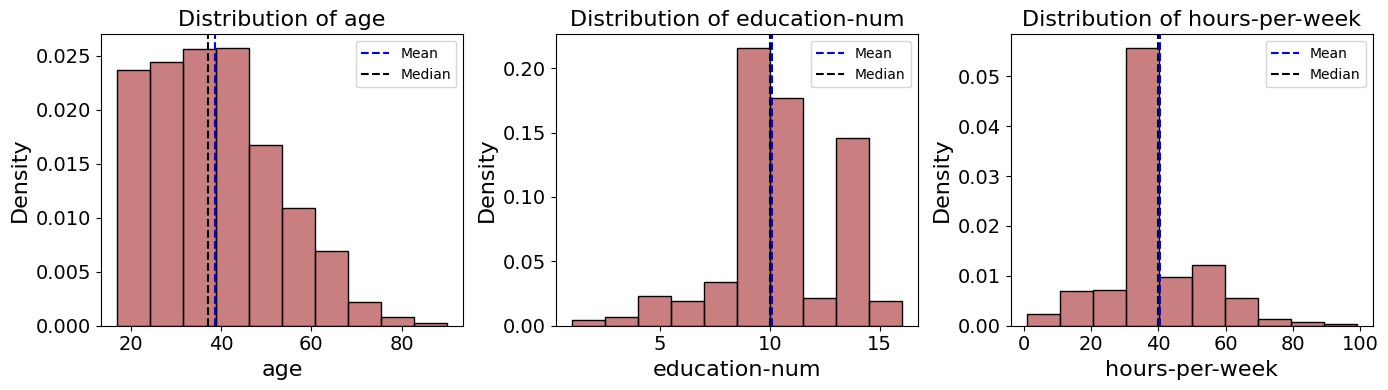

In [12]:
vars_of_interest = [
    "age",
    "education-num",
    "hours-per-week",
]

kde_distributions(
    df=df,
    n_rows=1,
    n_cols=3,
    subplot_figsize=(14, 4),  # Size of the overall grid figure
    text_wrap=50,
    hist_color="brown",
    bbox_inches="tight",
    vars_of_interest=vars_of_interest,
    y_axis_label="Density",
    bins=10,
    fill_alpha=0.60,
    plot_type="hist",
    stat="Density",
    label_fontsize=16,  # Font size for axis labels
    tick_fontsize=14,  # Font size for tick labels
    plot_mean=True,
    plot_median=True,
    mean_color="blue",
    image_filename="age_distribution_mean_median",
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

### Histogram Example - (Mean, Median, and Std. Deviation)

/tmp/ipykernel_164646/995977386.py:5: DeprecationWarning: `kde_distributions` is deprecated and will be removed in a future release. Use `plot_distributions` instead.
  kde_distributions(


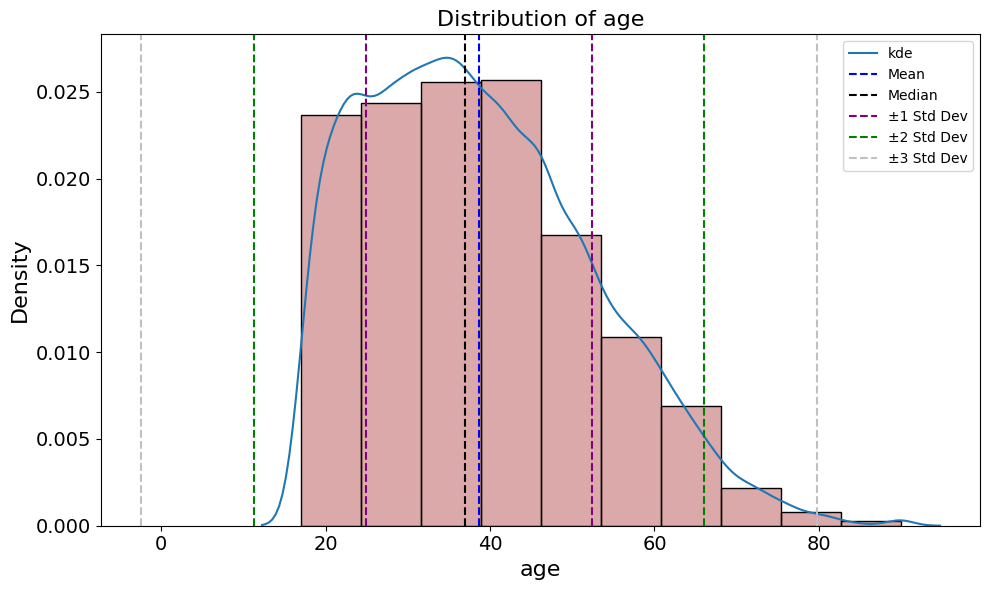

In [13]:
vars_of_interest = [
    "age",
]

kde_distributions(
    df=df,
    figsize=(10, 6),
    text_wrap=50,
    hist_color="brown",
    bbox_inches="tight",
    vars_of_interest=vars_of_interest,
    y_axis_label="Density",
    bins=10,
    fill_alpha=0.40,
    plot_type="both",
    stat="Density",
    label_fontsize=16,  # Font size for axis labels
    tick_fontsize=14,  # Font size for tick labels
    plot_mean=True,
    plot_median=True,
    mean_color="blue",
    image_path_svg=image_path_svg,
    image_path_png=image_path_png,
    std_dev_levels=[
        1,
        2,
        3,
    ],
    std_color=[
        "purple",
        "green",
        "silver",
    ],
    image_filename="age_distribution_mean_median_std",
)

/tmp/ipykernel_164646/3466498091.py:9: DeprecationWarning: `kde_distributions` is deprecated and will be removed in a future release. Use `plot_distributions` instead.
  kde_distributions(


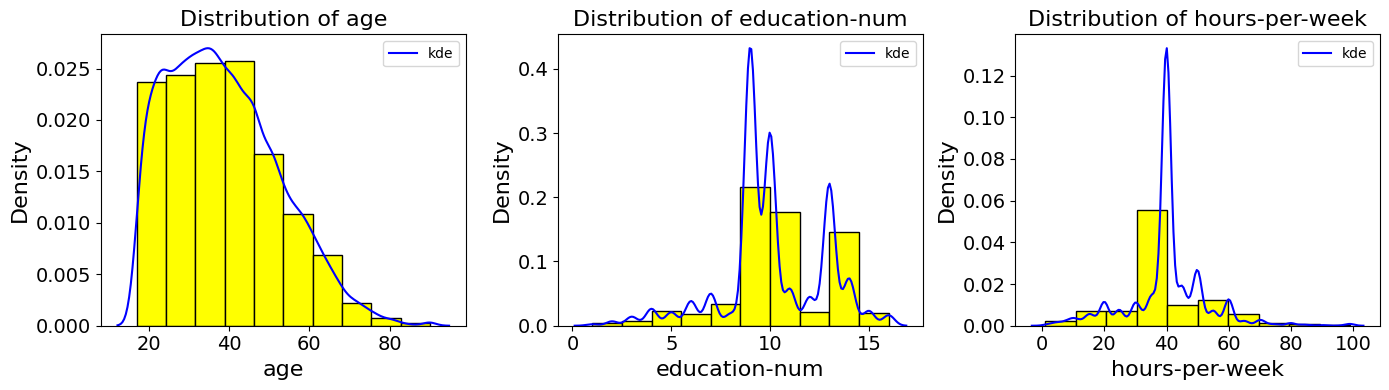

In [ ]:
# from eda_toolkit import plot_distributions

vars_of_interest = [
    "age",
    "education-num",
    "hours-per-week",
]

kde_distributions(
    df=df,
    vars_of_interest=vars_of_interest,
    # layout
    n_rows=1,
    n_cols=3,
    hue=None,
    hist_color="yellow",
    subplot_figsize=(14, 4),
    # plotting intent
    plot_type="both",  # histogram + density overlay
    stat="density",
    density_function="kde",
    density_color="blue",
    # histogram controls
    bins=10,
    fill=True,
    # labels & formatting
    y_axis_label="Density",
    text_wrap=50,
    label_fontsize=16,
    tick_fontsize=14,
    # output
    bbox_inches="tight",
    image_filename="age_distribution_norm_fit",
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
)

## Feature Scaling and Outliers

### Box-Cox Transformation Example 1

In [ ]:
df_doctor = df.copy()

In [ ]:
data_doctor(
    df=df_doctor,
    feature_name="age",
    data_fraction=0.6,
    scale_conversion="boxcox",
    apply_cutoff=False,
    lower_cutoff=None,
    upper_cutoff=None,
    show_plot=True,
    apply_as_new_col_to_df=True,
    random_state=111,
    figsize=(10, 3),
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plot=True,
)

In [ ]:
df.head()

### Box-Cox Transformation Example 2

In [ ]:
data_doctor(
    df=df_doctor,
    feature_name="age",
    data_fraction=1,
    scale_conversion="boxcox",
    apply_cutoff=False,
    lower_cutoff=None,
    upper_cutoff=None,
    show_plot=True,
    apply_as_new_col_to_df=True,
    scale_conversion_kws={"alpha": 0.8},
    box_violin="violinplot",
    box_violin_kws={"color": "lightblue"},
    kde_kws={"fill": True, "color": "blue"},
    hist_kws={"color": "green"},
    random_state=111,
    figsize=(10, 3),
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plot=True,
)

### Retaining a Sample for Analysis

In [ ]:
sampled_df = df_doctor.sample(frac=0.6, random_state=111)

In [ ]:
sampled_df.head()

In [ ]:
print(
    f"The sampled dataframe has {sampled_df.shape[0]} rows and {sampled_df.shape[1]} columns."
)

### Plain Outliers Example

In [ ]:
data_doctor(
    df=df_doctor,
    feature_name="fnlwgt",
    data_fraction=0.6,
    plot_type=["box_violin", "hist"],
    hist_kws={"color": "gray"},
    figsize=(8, 4),
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plot=True,
    random_state=111,
)

### Treated Outliers With Cutoffs

In [ ]:
data_doctor(
    df=df_doctor,
    feature_name="fnlwgt",
    data_fraction=0.6,
    apply_as_new_col_to_df=True,
    apply_cutoff=True,
    upper_cutoff=400000,
    plot_type=["box_violin", "hist"],
    hist_kws={"color": "gray", "bins": 20},
    figsize=(8, 4),
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plot=True,
    random_state=111,
)

### RobustScaler Outliers Examples

In [ ]:
data_doctor(
    df=df_doctor,
    feature_name="age",
    data_fraction=0.6,
    scale_conversion="robust",
    apply_as_new_col_to_df=True,
    scale_conversion_kws={
        "with_centering": False,  # Disable centering
        "quantile_range": (10.0, 90.0),  # Use a custom quantile range
    },
    random_state=111,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plot=True,
)

## Stacked Crosstab Plots

### Stacked Bar Plots With Crosstabs Example

In [ ]:
df = strip_trailing_period(df=df_doctor, column_name="income")

In [ ]:
# Define the func_col to use in the loop in order of usage
func_col = ["sex", "income"]

# Define the legend_labels to use in the loop
legend_labels_list = [
    ["Male", "Female"],  # Corresponds to "sex"
    ["<=50K", ">50K"],  # Corresponds to "income"
]

# Define titles for the plots
title = [
    "Sex",
    "Income",
]

In [ ]:
# Call the stacked_crosstab_plot function
stacked_crosstabs = stacked_crosstab_plot(
    df=df,
    col="age_group",
    func_col=func_col,
    legend_labels_list=legend_labels_list,
    title=title,
    kind="bar",
    width=0.8,
    rot=0,  # axis rotation angle
    custom_order=None,
    color=["#00BFC4", "#F8766D"],  # default color schema
    output="plots_only",
    return_dict=True,
    x=14,
    y=8,
    p=10,
    logscale=False,
    plot_type="both",
    show_legend=True,
    label_fontsize=14,
    tick_fontsize=12,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    file_prefix="stacked_bar",
    save_formats=["png", "svg"],
)

In [ ]:
crosstab_age_sex = stacked_crosstabs["sex"]
crosstab_age_income = stacked_crosstabs["income"]

In [ ]:
crosstab_age_sex

In [ ]:
crosstab_age_income

### Non-Normalized Stacked Bar Plots Example

In [ ]:
# Call the stacked_crosstab_plot function
stacked_crosstabs = stacked_crosstab_plot(
    df=df,
    col="age_group",
    func_col=func_col,
    legend_labels_list=legend_labels_list,
    title=title,
    kind="bar",
    width=0.8,
    rot=0,  # axis rotation angle
    custom_order=None,
    color=["#00BFC4", "#F8766D"],  # default color schema
    output="both",
    return_dict=True,
    x=14,
    y=8,
    p=10,
    logscale=False,
    plot_type="regular",
    show_legend=True,
    label_fontsize=14,
    tick_fontsize=12,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    file_prefix="stacked_bar_non_normalized",
    save_formats=["png", "svg"],
)

## Regular Non-Stacked Bar Plots Example

In [ ]:
# Call the stacked_crosstab_plot function
stacked_crosstabs = stacked_crosstab_plot(
    df=df,
    col="age_group",
    func_col=func_col,
    legend_labels_list=legend_labels_list,
    title=title,
    kind="bar",
    width=0.8,
    rot=0,  # axis rotation angle
    custom_order=None,
    color="#333333",
    output="both",
    return_dict=True,
    x=14,
    y=8,
    p=10,
    logscale=False,
    plot_type="regular",
    show_legend=True,
    label_fontsize=14,
    tick_fontsize=12,
    remove_stacks=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    file_prefix="unstacked_bar",
    save_formats=["png", "svg"],
)

## Box and Violin Plots

### Box Plots Grid Example

In [ ]:
age_boxplot_list = df[
    [
        "education-num",
        "hours-per-week",
    ]
].columns.to_list()

In [ ]:
metrics_comp = ["age_group"]

box_violin_plot(
    df=df,
    metrics_list=age_boxplot_list,
    metrics_comp=metrics_comp,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plots=True,
    show_plot="both",
    show_legend=False,
    plot_type="boxplot",
    xlabel_rot=90,
)

### Violin Plots Grid Example

In [ ]:
metrics_comp = ["age_group"]

box_violin_plot(
    df=df,
    metrics_list=age_boxplot_list,
    metrics_comp=metrics_comp,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    # save_plots=True,
    show_plot="both",
    show_legend=False,
    plot_type="violinplot",
    xlabel_rot=90,
)

### Pivoted Violin Plots Grid Example

In [ ]:
metrics_comp = ["age_group"]

box_violin_plot(
    df=df,
    metrics_list=age_boxplot_list,
    metrics_comp=metrics_comp,
    show_plot="both",
    rotate_plot=True,
    show_legend=False,
    plot_type="violinplot",
    xlabel_rot=0,
)

## Scatter Plots and Best Fit Lines

### Regression-Centric Scatter Plots Example

In [ ]:
df = df.drop(columns=["age_boxcox", "fnlwgt_w_cutoff", "age_robust"])

In [ ]:
scatter_fit_plot(
    df=df,
    # x_vars=["age", "education-num"],
    # y_vars=["hours-per-week"],
    all_vars=df.select_dtypes(np.number).columns.to_list(),
    show_legend=True,
    n_cols=6,
    show_plot="subplots",
    subplot_figsize=None,
    label_fontsize=14,
    tick_fontsize=12,
    add_best_fit_line=True,
    scatter_color="#808080",
    show_correlation=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plots="all",
)

### Scatter Plots Grouped by Category Example

In [ ]:
hue_dict = {"<=50K": "brown", ">50K": "green"}

scatter_fit_plot(
    df=df,
    x_vars=["age", "education-num"],
    y_vars=["hours-per-week"],
    show_legend=True,
    show_plot="subplots",
    label_fontsize=14,
    tick_fontsize=12,
    add_best_fit_line=False,
    scatter_color="#808080",
    hue="income",
    hue_palette=hue_dict,
    show_correlation=False,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plots="all",
)

### Scatter Plots (All Combinations Example)

In [ ]:
## Reload dataframe since a ton of `data_doctor` columns were added from above;
## this would cause too many additional columns to loop through; not necessary
## for this reproducible example, especially when it comes to saving so many files
df = pd.read_csv(os.path.join(data_path, "adult_income.csv"))
df = df.drop(columns=["Unnamed: 0"])

In [ ]:
scatter_fit_plot(
    df=df,
    all_vars=df.select_dtypes(np.number).columns.to_list(),
    show_legend=True,
    show_plot="subplots",
    label_fontsize=14,
    tick_fontsize=12,
    add_best_fit_line=True,
    scatter_color="#808080",
    show_correlation=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plots="all",
)

In [ ]:
exclude_combinations = [
    ("capital-gain", "hours-per-week"),
    ("capital-loss", "capital-gain"),
    ("capital-loss", "hours-per-week"),
    ("capital-loss", "education-num"),
    ("capital-loss", "fnlwgt"),
    ("education-num", "hours-per-week"),
    ("hours-per-week", "age"),
]

scatter_fit_plot(
    df=df,
    all_vars=df.select_dtypes(np.number).columns.to_list(),
    show_legend=True,
    exclude_combinations=exclude_combinations,
    show_plot="combinations",
    label_fontsize=14,
    tick_fontsize=12,
    add_best_fit_line=True,
    scatter_color="#808080",
    show_correlation=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plots="grid",
)

## Correlation Matrices

### Triangular Correlation Matrix Example

In [ ]:
# Select only numeric data to pass into the function
df_num = df.select_dtypes(np.number)

In [ ]:
flex_corr_matrix(
    df=df,
    cols=df_num.columns.to_list(),
    annot=True,
    cmap="coolwarm",
    figsize=(10, 8),
    title="US Census Correlation Matrix",
    xlabel_alignment="right",
    label_fontsize=14,
    tick_fontsize=12,
    xlabel_rot=45,
    ylabel_rot=0,
    text_wrap=50,
    vmin=-1,
    vmax=1,
    cbar_label="Correlation Index",
    triangular=True,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plots=True,
)

### Full Correlation Matrix Example

In [ ]:
flex_corr_matrix(
    df=df,
    cols=df_num.columns.to_list(),
    annot=True,
    cmap="viridis",
    figsize=(10, 8),
    title="US Census Correlation Matrix",
    xlabel_alignment="right",
    label_fontsize=14,
    tick_fontsize=12,
    xlabel_rot=45,
    ylabel_rot=0,
    text_wrap=50,
    vmin=-1,
    vmax=1,
    cbar_label="Correlation Index",
    triangular=False,
    image_path_png=image_path_png,
    image_path_svg=image_path_svg,
    save_plots=True,
)

## Outcome Crosstab Plot Examples

### Clean up income column by removing trailing period

In [ ]:
df["income"] = df["income"].astype(str)
## Clean target column by removing trailing period
df.loc[:, "income"] = df["income"].str.rstrip(".")

# Display class balance
print(f"\nBreakdown of y:\n{df['income'].value_counts()}\n")

### Identify binary columns

In [ ]:
bar_list = ["race", "sex"]

In [ ]:
from eda_toolkit import outcome_crosstab_plot

outcome_crosstab_plot(
    df=df,
    list_name=bar_list,
    label_0="<=50k",
    label_1=">50K",
    figsize=(10, 6),
    normalize=False,
    image_path_svg=image_path_svg,
    image_path_png=image_path_png,
    string="outcome_by_feature",
    save_plots=True,
    outcome="income",
    show_value_counts=True,
    # color_schema=surg_tech_color,
)